In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
import contractions
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
import numpy as np
import fasttext
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import torch.nn.functional as F
import torch

import networkx as nx
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import norm
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import global_mean_pool

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from torch_geometric.nn import GraphConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

from tqdm import tqdm

import random

sns.set_theme()

# Set fixed random number seed
#torch.manual_seed(42)

%matplotlib inline

In [2]:
def calculate_accuracy_precision_recall(true_labels, predicted_labels):
    return (accuracy_score(true_labels, predicted_labels),
           precision_score(true_labels, predicted_labels),
           recall_score(true_labels, predicted_labels))

def print_evaluation_results(results):
    print('Avg accuracy | Avg precision | Avg recall')
    avg_accuracy, avg_precision, avg_recall = np.mean(results, axis=0)
    std_accuracy, std_precision, std_recall = np.std(results, axis=0)
    print(f'{avg_accuracy:.4f}+-{std_accuracy:.4f}, {avg_precision:.4f}+-{std_precision:.4f}, {avg_recall:.4f}+-{std_recall:.4f}')

def get_random_number():
    return random.randint(0, 10000)

global_random_number = get_random_number()
global_random_numbers = [get_random_number() for _ in range(10)]

## Load dataset

In [3]:
df = pd.read_csv('samples.csv')
# bug == 0 and feature == 1
df = df[(df['label'] == 0) | (df['label'] == 1)]
#df = df[:500]
len(df)

407799

## Preprocess dataset

In [4]:
contractions.add('__label__', 'REMOVED_TOKEN')

In [5]:
# fix contractions
df['title'] = df['title'].apply(contractions.fix)
df['body'] = df['body'].apply(contractions.fix)

In [6]:
# removal of stopwords
df['title'] = df['title'].apply(remove_stopwords)
df['body'] = df['body'].apply(remove_stopwords)

## Generate statistics

In [7]:
df['number_of_words_of_title'] = df['title'].str.split().str.len()
df['number_of_words_of_body'] = df['body'].str.split().str.len()

In [8]:
x = df['number_of_words_of_title']

In [9]:
x.describe()

count    407799.000000
mean          4.966165
std           2.007483
min           0.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          43.000000
Name: number_of_words_of_title, dtype: float64

Text(0.5, 0, 'Number of words of title')

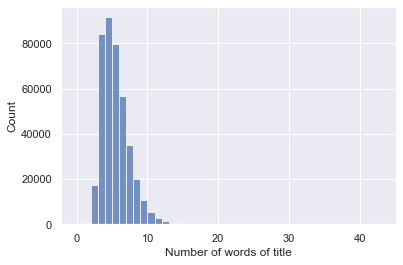

In [10]:
fig = sns.histplot(data=df, x='number_of_words_of_title', kde=False, stat='count', binwidth=1)
fig.set_xlabel('Number of words of title')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

Text(0.5, 0, 'Number of words of body')

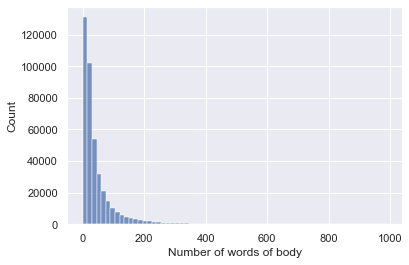

In [11]:
fig = sns.histplot(data=df, x='number_of_words_of_body', kde=False, stat='count', binwidth=15)
fig.set_xlabel('Number of words of body')
#fig.get_figure().savefig('figures/price_kde_histogram.jpg', dpi=500)

In [12]:
df['number_of_words_of_title'].describe()

count    407799.000000
mean          4.966165
std           2.007483
min           0.000000
25%           3.000000
50%           5.000000
75%           6.000000
max          43.000000
Name: number_of_words_of_title, dtype: float64

In [13]:
df['number_of_words_of_body'].describe()

count    407799.000000
mean         45.938685
std          63.545595
min           0.000000
25%          12.000000
50%          24.000000
75%          52.000000
max         977.000000
Name: number_of_words_of_body, dtype: float64

In [14]:
# bugs == 0
# feature == 1
df['label'].value_counts()

1    207318
0    200481
Name: label, dtype: int64

In [15]:
x_train, x_test = train_test_split(df.body, test_size=0.33, random_state=42)
print('Train size', len(x_train))
print('Test size', len(x_test))

Train size 273225
Test size 134574


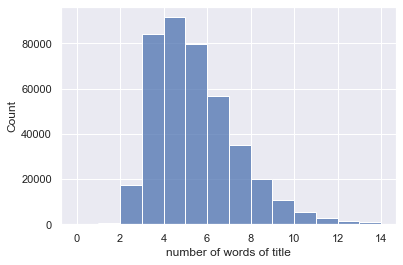

In [16]:
fig = sns.histplot(data=df[df['number_of_words_of_title'] < 15], x='number_of_words_of_title', kde=False, stat='count', binwidth=1)
fig.set_xlabel('number of words of title')
fig.get_figure().savefig('figures/number_of_words_of_title_less_than_15.pdf', dpi=500)

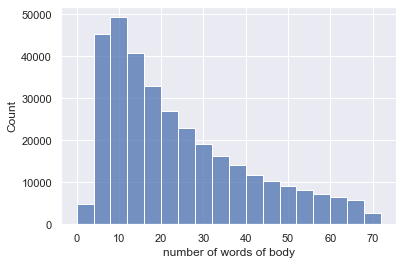

In [17]:
fig = sns.histplot(data=df[df['number_of_words_of_body'] < 70], x='number_of_words_of_body', kde=False, stat='count', binwidth=4)
fig.set_xlabel('number of words of body')
fig.get_figure().savefig('figures/number_of_words_of_body_less_than_70.pdf', dpi=500)

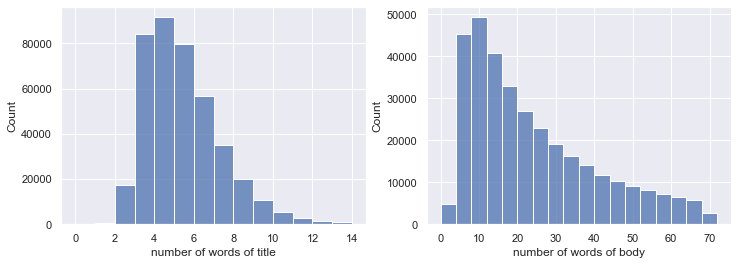

In [18]:
# print altogether
fig, ax = plt.subplots(1,2)
fig.set_figwidth(12)
ax[0].set_xlabel('number of words of title')
ax[1].set_xlabel('number of words of body')
sns.histplot(data=df[df['number_of_words_of_title'] < 15], x='number_of_words_of_title', kde=False, stat='count', binwidth=1, ax=ax[0])
sns.histplot(data=df[df['number_of_words_of_body'] < 70], x='number_of_words_of_body', kde=False, stat='count', binwidth=4, ax=ax[1])
fig.savefig('figures/title_words_less_than_15_body_words_less_than_70.pdf', dpi=500)

## Load glove embeddings 100

In [19]:
glove2word2vec('glove.6B/glove.6B.100d.txt', 'tmpfile_glove')
glove_embeddings_model = KeyedVectors.load_word2vec_format('tmpfile_glove')

In [20]:
def get_word_glove_embedding(word):
    if word not in glove_embeddings_model:
        return np.zeros(100, dtype='float32')
    return glove_embeddings_model.get_vector(word)

In [21]:
def get_sentence_glove_embedding(sentence):
    word_embeddings = [glove_embeddings_model.get_vector(word) if word in glove_embeddings_model else np.zeros(100, dtype='float32') for word in sentence.split()]
    if len(word_embeddings) == 0:
        return np.zeros(100, dtype='float32')
    return np.mean(word_embeddings, axis=0)

## Train fasttext embeddings

In [22]:
df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
np.savetxt('train.txt', train_input, fmt='%s')
np.savetxt('test.txt', test_input, fmt='%s')
fasttext_model = fasttext.train_supervised('train.txt', dim=100, epoch=5)
fasttext_model.test('test.txt')
df.drop('fasttext_input', axis=1, inplace=True)
embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

## Train baseline models

## GloVe + logistic regression classification

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
X_train = [get_sentence_glove_embedding(s) for s in X_train.values]
X_test = [get_sentence_glove_embedding(s) for s in X_test.values]

In [24]:
def run_logistic_regression_classifier(use_global_random_number=True):
    if use_global_random_number:
        random_state = global_random_number
    else:
        random_state = get_random_number()
    logit_clf = LogisticRegression(random_state=random_state, solver='liblinear').fit(X_train, y_train)
    predicted_labels = logit_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [25]:
logit_evaluation_results = [run_logistic_regression_classifier()]

(0.722695320046963, 0.7408314087759815, 0.7013935453776858)


## <font color='red'>GloVe + logistic regression results</font>

In [26]:
print_evaluation_results(logit_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7227+-0.0000, 0.7408+-0.0000, 0.7014+-0.0000


## GloVe + knn

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
def run_knn_regression_classifier():
    knn_clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
    predicted_labels = knn_clf.predict(X_test)
    true_labels = y_test
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [29]:
knn_evaluation_results = [run_knn_regression_classifier()]

(0.6918052521289402, 0.7341481519843942, 0.6199090405527535)


## <font color='red'>GloVe + knn results</font>

In [30]:
print_evaluation_results(knn_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.6918+-0.0000, 0.7341+-0.0000, 0.6199+-0.0000


## Fasttext classification

In [31]:
def run_fasttext_classifier():
    df['fasttext_input'] = '__label__' + df['label'].map(str) + ' ' + df['title'] + ' ' + df['body']
    train_input, test_input = train_test_split(df.fasttext_input.values, test_size=0.33, random_state=42)
    np.savetxt('train.txt', train_input, fmt='%s')
    np.savetxt('test.txt', test_input, fmt='%s')
    fasttext_model = fasttext.train_supervised('train.txt', dim=100, epoch=5)
    fasttext_model.test('test.txt')
    df.drop('fasttext_input', axis=1, inplace=True)
    embeddings_lookup = {word: fasttext_model.get_word_vector(word) for word in fasttext_model.get_words()}

    _, test_df = train_test_split(df, test_size=0.33, random_state=42)
    predicted_labels = [int(res[0].split('__label__')[1]) for res in fasttext_model.predict(test_df['body'].values.tolist())[0]]
    true_labels = test_df['label'].values
    
    results = calculate_accuracy_precision_recall(true_labels, predicted_labels)
    print(results)
    return results

In [32]:
fasttext_evaluation_results = []
for num in global_random_numbers:
    fasttext_evaluation_results.append(run_fasttext_classifier())

(0.7970038789067725, 0.8099678649728204, 0.7862598758053702)
(0.796795814941965, 0.8104102085653234, 0.7850354217078219)
(0.7965208732741837, 0.8102952468420181, 0.7845106556660155)
(0.7967735223743071, 0.8103642847469869, 0.7850499985423165)
(0.7968849852125968, 0.8102670516059184, 0.7854873035771552)
(0.7967215063831052, 0.8104564340338412, 0.7847730386869187)
(0.7970113097626584, 0.8108014514356264, 0.7849771143698434)
(0.796766091518421, 0.8106044634520977, 0.7846564240109618)
(0.7966323361124734, 0.8107684423140695, 0.7840587737966823)
(0.7963945487241221, 0.8131802979629067, 0.7797294539517798)


## <font color='red'>Fasttext results</font>

In [33]:
print_evaluation_results(fasttext_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7968+-0.0002, 0.8107+-0.0009, 0.7845+-0.0017


## MLP

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

x_train, x_test, y_train, y_test = train_test_split(df.body, df.label, test_size=0.33, random_state=42)
x_train = [get_sentence_glove_embedding(s) for s in x_train.values]
x_test = [get_sentence_glove_embedding(s) for s in x_test.values]

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train.values).float()

x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test.values).float()

x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

BATCH_SIZE = 255

# generate train dataset and train dataloader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# generate test dataset
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

cuda


In [35]:
class MLP(torch.nn.Module):
    def __init__(self) : 
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(100 , 250)
        self.linear2 = torch.nn.Linear(250, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

In [36]:
def run_mlp_classifier():
    # Initialize the MLP
    mlp = MLP().to(device)

    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

    mlp.train()
    # Run the training loop
    for epoch in range(0, 50):
        # Iterate over the DataLoader for training data
        for i, (inputs, targets) in enumerate(train_dataloader):
            # Get inputs
            targets = targets.squeeze()

            # Perform forward pass
            outputs = mlp(inputs)
            outputs = outputs.squeeze()

            # Compute loss
            loss = loss_function(outputs, targets)


            # Perform backward pass
            loss.backward()
            # Perform optimization
            optimizer.step()
            # Zero the gradients
            optimizer.zero_grad()

        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')
    # Process is complete.
    print('Training process has finished.')
    print('Final loss', loss.item())
    
    with torch.no_grad():
        mlp.eval()
        pred = mlp(test_dataset.tensors[0].to(device))
        y_true = test_dataset.tensors[1].tolist()
        y_pred = torch.round(torch.tensor(pred.tolist()).squeeze())
        results = calculate_accuracy_precision_recall(y_true, y_pred)

    print(results)
    return results

In [37]:
mlp_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    mlp_evaluation_results.append(run_mlp_classifier())

Epoch: 0, Epoch loss 0.5425767302513123
Epoch: 1, Epoch loss 0.5169662237167358
Epoch: 2, Epoch loss 0.518658459186554
Epoch: 3, Epoch loss 0.5014069676399231
Epoch: 4, Epoch loss 0.5177818536758423
Epoch: 5, Epoch loss 0.49739736318588257
Epoch: 6, Epoch loss 0.49598562717437744
Epoch: 7, Epoch loss 0.48850423097610474
Epoch: 8, Epoch loss 0.4839492738246918
Epoch: 9, Epoch loss 0.49732571840286255
Epoch: 10, Epoch loss 0.47213849425315857
Epoch: 11, Epoch loss 0.479128360748291
Epoch: 12, Epoch loss 0.47558727860450745
Epoch: 13, Epoch loss 0.46878767013549805
Epoch: 14, Epoch loss 0.4721163809299469
Epoch: 15, Epoch loss 0.47493794560432434
Epoch: 16, Epoch loss 0.46507397294044495
Epoch: 17, Epoch loss 0.47199124097824097
Epoch: 18, Epoch loss 0.47822514176368713
Epoch: 19, Epoch loss 0.47574159502983093
Epoch: 20, Epoch loss 0.4753439128398895
Epoch: 21, Epoch loss 0.4719352722167969
Epoch: 22, Epoch loss 0.468707799911499
Epoch: 23, Epoch loss 0.45837756991386414
Epoch: 24, Epoch

Epoch: 41, Epoch loss 0.4371396601200104
Epoch: 42, Epoch loss 0.44147786498069763
Epoch: 43, Epoch loss 0.4493248760700226
Epoch: 44, Epoch loss 0.42611163854599
Epoch: 45, Epoch loss 0.4553895592689514
Epoch: 46, Epoch loss 0.43687373399734497
Epoch: 47, Epoch loss 0.45558905601501465
Epoch: 48, Epoch loss 0.43300411105155945
Epoch: 49, Epoch loss 0.4346105456352234
Training process has finished.
Final loss 0.4346105456352234
(0.7400909536760444, 0.7535554315532297, 0.7283461123582403)
Epoch: 0, Epoch loss 0.5399306416511536
Epoch: 1, Epoch loss 0.5156222581863403
Epoch: 2, Epoch loss 0.5187715291976929
Epoch: 3, Epoch loss 0.5158010721206665
Epoch: 4, Epoch loss 0.5025883316993713
Epoch: 5, Epoch loss 0.503743052482605
Epoch: 6, Epoch loss 0.4855218231678009
Epoch: 7, Epoch loss 0.4885229170322418
Epoch: 8, Epoch loss 0.48486465215682983
Epoch: 9, Epoch loss 0.483433336019516
Epoch: 10, Epoch loss 0.48306092619895935
Epoch: 11, Epoch loss 0.46998682618141174
Epoch: 12, Epoch loss 0.

Epoch: 29, Epoch loss 0.4703826606273651
Epoch: 30, Epoch loss 0.449556827545166
Epoch: 31, Epoch loss 0.4553355872631073
Epoch: 32, Epoch loss 0.46769723296165466
Epoch: 33, Epoch loss 0.44187095761299133
Epoch: 34, Epoch loss 0.45052918791770935
Epoch: 35, Epoch loss 0.4474179148674011
Epoch: 36, Epoch loss 0.45516371726989746
Epoch: 37, Epoch loss 0.4464223086833954
Epoch: 38, Epoch loss 0.4592067301273346
Epoch: 39, Epoch loss 0.44575953483581543
Epoch: 40, Epoch loss 0.44845032691955566
Epoch: 41, Epoch loss 0.45768865942955017
Epoch: 42, Epoch loss 0.46398302912712097
Epoch: 43, Epoch loss 0.43874767422676086
Epoch: 44, Epoch loss 0.42483699321746826
Epoch: 45, Epoch loss 0.4493561089038849
Epoch: 46, Epoch loss 0.4376632273197174
Epoch: 47, Epoch loss 0.44376763701438904
Epoch: 48, Epoch loss 0.4349769353866577
Epoch: 49, Epoch loss 0.4476027488708496
Training process has finished.
Final loss 0.4476027488708496
(0.7397565651611753, 0.7543939393939394, 0.7257805894871869)
Epoch: 

## <font color='red'>GloVe + MLP results</font>

In [38]:
print_evaluation_results(mlp_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7401+-0.0002, 0.7544+-0.0006, 0.7268+-0.0013


## Train our model

In [39]:
def create_graph_of_words(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = embeddings_lookup.get(word, np.zeros(100, dtype='float32'))
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch(text, window_size):
    return from_networkx(create_graph_of_words(text, window_size))

def generate_pytorch_geometric_graphs(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GATConv(100, 10, heads=3)
        self.linear1 = torch.nn.Linear(10*3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [40]:
pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=7)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [15:56<00:00, 426.54it/s]


finished...


In [41]:
train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)

In [42]:
def run_gat_classifier(train_pyg_graphs, test_pyg_graphs, train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs, batch_size=200, shuffle=False)
    
    gat_model = GATClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [43]:
gat_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gat_evaluation_results.append(run_gat_classifier(train_pyg_graphs, test_pyg_graphs))

GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.34297236800193787
Epoch: 1, Epoch loss 0.3586287200450897
Epoch: 2, Epoch loss 0.3365243673324585
Epoch: 3, Epoch loss 0.3382684886455536
Epoch: 4, Epoch loss 0.3431403934955597
Epoch: 5, Epoch loss 0.3433286249637604
Epoch: 6, Epoch loss 0.35072964429855347
Epoch: 7, Epoch loss 0.3392132520675659
Epoch: 8, Epoch loss 0.3323723077774048
Epoch: 9, Epoch loss 0.3296910524368286
Training process has finished.
Final loss 0.3296910524368286
(0.802257494018161, 0.8154955933840397, 0.7897636759569151)
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.34482577443122864
Epoch: 1, Epoch loss 0.3521638512611389
Epoch: 2, Epoch loss 0.33709436655044556
Epoch: 3, Epoch loss 0.3504785895347595
Epoch: 4, Epoch loss 0.328925609588

## <font color='red'>Our approach results</font>

In [44]:
print_evaluation_results(gat_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.8022+-0.0002, 0.8125+-0.0024, 0.7943+-0.0036


## Glove + GATConv

In [45]:
def create_graph_of_words_glove(text, window_size):
    text = text.split()
    G = nx.Graph()
    for i, word in enumerate(text):
        #embedding = fasttext_model.get_word_vector(word)
        embedding = get_word_glove_embedding(word)
        G.add_node(word, x=embedding)
        for j in range(i + 1, i + window_size):
            if j < len(text):
                G.add_edge(word, text[j])
    return G

def create_graph_of_words_for_pytorch_glove(text, window_size):
    return from_networkx(create_graph_of_words_glove(text, window_size))

def generate_pytorch_geometric_graphs_glove(window_size):
    pyg_graphs = []
    for s in tqdm(df['body'].values):
        pyg_graphs.append(create_graph_of_words_for_pytorch_glove(s, window_size))
    print('finished...')
    for i, label in enumerate(df['label'].values):
        pyg_graphs[i].y = torch.tensor(label).float()
    
    pyg_graphs = [g for g in pyg_graphs if g.num_nodes != 0]
    return pyg_graphs

class GATGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GATConv(100, 10, heads=3)
        self.linear1 = torch.nn.Linear(10*3, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [46]:
pytorch_geometric_graphs_glove = generate_pytorch_geometric_graphs_glove(window_size=7)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [16:04<00:00, 422.77it/s]


finished...


In [47]:
train_pyg_graphs_glove, test_pyg_graphs_glove = train_test_split(pytorch_geometric_graphs_glove, test_size=0.33, random_state=42)

In [48]:
def run_gat_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    gat_model = GATGloveClassifier().to(device)
    print(gat_model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(gat_model.parameters(), lr=learning_rate)

    gat_model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = gat_model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        gat_model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = gat_model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [49]:
gat_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gat_glove_evaluation_results.append(run_gat_glove_classifier())

GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5408297777175903
Epoch: 1, Epoch loss 0.5366239547729492
Epoch: 2, Epoch loss 0.5173269510269165
Epoch: 3, Epoch loss 0.5082159042358398
Epoch: 4, Epoch loss 0.5210191607475281
Epoch: 5, Epoch loss 0.5007474422454834
Epoch: 6, Epoch loss 0.5049952268600464
Epoch: 7, Epoch loss 0.5132017135620117
Epoch: 8, Epoch loss 0.5232371091842651
Epoch: 9, Epoch loss 0.497927725315094
Training process has finished.
Final loss 0.497927725315094
(0.765615943644389, 0.7786542152107228, 0.7530947196118264)
GATGloveClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.522725522518158
Epoch: 1, Epoch loss 0.5212802886962891
Epoch: 2, Epoch loss 0.5107335448265076
Epoch: 3, Epoch loss 0.5224583148956299
Epoch: 4, Epoch loss 0.509634673

## <font color='red'>GloVe + GATConv results</font>

In [50]:
print_evaluation_results(gat_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7651+-0.0006, 0.7776+-0.0022, 0.7537+-0.0034


## Glove + GCNonv

In [51]:
class GCNGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GCNConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [52]:
def run_gcn_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GCNGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [53]:
gcn_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    gcn_glove_evaluation_results.append(run_gcn_glove_classifier())

GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5825007557868958
Epoch: 1, Epoch loss 0.5618257522583008
Epoch: 2, Epoch loss 0.5575379133224487
Epoch: 3, Epoch loss 0.5626052618026733
Epoch: 4, Epoch loss 0.5557960271835327
Epoch: 5, Epoch loss 0.5693235993385315
Epoch: 6, Epoch loss 0.5492316484451294
Epoch: 7, Epoch loss 0.5743678212165833
Epoch: 8, Epoch loss 0.5640936493873596
Epoch: 9, Epoch loss 0.5672258138656616
Training process has finished.
Final loss 0.5672258138656616
(0.7297769257063028, 0.7493699243909269, 0.7039738099761776)
GCNGloveClassifier(
  (conv1): GCNConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5679458975791931
Epoch: 1, Epoch loss 0.5974653959274292
Epoch: 2, Epoch loss 0.5679051876068115
Epoch: 3, Epoch loss 0.55149906873703
Epoch: 4, Epoch loss 0.5719053149223328
Epoch: 5

## <font color='red'>GloVe + GCNConv results</font>

In [54]:
print_evaluation_results(gcn_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7295+-0.0001, 0.7475+-0.0023, 0.7068+-0.0043


## Glove + GraphConv

In [55]:
class GraphConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = GraphConv(100, 10, aggr='mean')
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [56]:
def run_graphconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = GraphConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [57]:
graphconv_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    graphconv_glove_evaluation_results.append(run_graphconv_glove_classifier())

GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5745275020599365
Epoch: 1, Epoch loss 0.5559797883033752
Epoch: 2, Epoch loss 0.5496010184288025
Epoch: 3, Epoch loss 0.548589825630188
Epoch: 4, Epoch loss 0.5505567193031311
Epoch: 5, Epoch loss 0.5432544946670532
Epoch: 6, Epoch loss 0.5322282314300537
Epoch: 7, Epoch loss 0.5395486950874329
Epoch: 8, Epoch loss 0.5422508716583252
Epoch: 9, Epoch loss 0.5387610197067261
Training process has finished.
Final loss 0.5387610197067261
(0.7493349383982048, 0.7614561350618029, 0.7382751413998216)
GraphConvGloveClassifier(
  (conv1): GraphConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5583705902099609
Epoch: 1, Epoch loss 0.5755577087402344
Epoch: 2, Epoch loss 0.5558893084526062
Epoch: 3, Epoch loss 0.5428469777107239
Epoch: 4, Epoch loss 0.55941975

## <font color='red'>GloVe + GraphConv results</font>

In [58]:
print_evaluation_results(graphconv_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7493+-0.0006, 0.7642+-0.0025, 0.7331+-0.0049


## Glove + SAGEConv

In [59]:
class SAGEConvGloveClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #torch.manual_seed(12345)
        
        self.conv1 = SAGEConv(100, 10)
        self.linear1 = torch.nn.Linear(10, 1)
        
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, data, batch):
        x, edge_index = data.x, data.edge_index
        
        x = F.elu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear1(x)
        x = self.sigmoid(x)
        
        return x

In [60]:
def run_sageconv_glove_classifier(train_batch_size=300, learning_rate=0.001, num_epoch=10):
    train_loader = DataLoader(train_pyg_graphs_glove, batch_size=train_batch_size, shuffle=False)
    test_loader = DataLoader(test_pyg_graphs_glove, batch_size=200, shuffle=False)
    
    model = SAGEConvGloveClassifier().to(device)
    print(model)
    # Define the loss function and optimizer
    loss_function = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(0, num_epoch):
        for i, data in enumerate(train_loader):  # Iterate in batches over the training dataset.
            data = data.to(device)
            try:
                out = model(data, data.batch)  # Perform a single forward pass.
            except Exception as e:
                print(data)
                print(data.x)
                print(data.y)
            out = out.squeeze()
            y = data.y.squeeze()
            loss = loss_function(out, y)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
        print(f'Epoch: {epoch}, Epoch loss {loss.item()}')

    print('Training process has finished.')
    print('Final loss', loss.item())
    
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            data = data.to(device)
            out = model(data, data.batch)
            pred_labels.extend(torch.round(out.squeeze()).tolist())
            true_labels.extend(data.y.tolist())
    
    results = calculate_accuracy_precision_recall(true_labels, pred_labels)
    
    print(results)
    return results

In [61]:
sageconv_glove_evaluation_results = []
for num in global_random_numbers:
    torch.manual_seed(num)
    sageconv_glove_evaluation_results.append(run_sageconv_glove_classifier())

SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5745275020599365
Epoch: 1, Epoch loss 0.55597984790802
Epoch: 2, Epoch loss 0.5496010184288025
Epoch: 3, Epoch loss 0.548589825630188
Epoch: 4, Epoch loss 0.5505567193031311
Epoch: 5, Epoch loss 0.5432544946670532
Epoch: 6, Epoch loss 0.5322282314300537
Epoch: 7, Epoch loss 0.5395486950874329
Epoch: 8, Epoch loss 0.54225093126297
Epoch: 9, Epoch loss 0.5387610197067261
Training process has finished.
Final loss 0.5387610197067261
(0.7493349383982048, 0.7614561350618029, 0.7382751413998216)
SAGEConvGloveClassifier(
  (conv1): SAGEConv(100, 10)
  (linear1): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.5583705902099609
Epoch: 1, Epoch loss 0.5755577087402344
Epoch: 2, Epoch loss 0.5558893084526062
Epoch: 3, Epoch loss 0.5428469777107239
Epoch: 4, Epoch loss 0.5594196915626526

## <font color='red'>GloVe + SAGEConv results</font>

In [62]:
print_evaluation_results(sageconv_glove_evaluation_results)

Avg accuracy | Avg precision | Avg recall
0.7493+-0.0006, 0.7642+-0.0025, 0.7331+-0.0049


In [84]:
del pytorch_geometric_graphs_glove
del train_pyg_graphs_glove
del test_pyg_graphs_glove

# Parameter Sensitivity

In [85]:
torch.manual_seed(12345)

## Sliding window

In [63]:
def run_sliding_window_experiments():
    sliding_windows = [2, 3, 4, 6, 7, 10]
    
    sliding_window_results = []
    for sw in sliding_windows:
        print('Window size:', sw)
        pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=sw)
        train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
        sliding_window_results.append((sw, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)))
    return sliding_window_results

In [64]:
sliding_window_results = run_sliding_window_experiments()
sliding_window_results = [[sw, results[0]] for sw, results in sliding_window_results]

  0%|                                                                                                                                  | 36/407799 [00:00<21:14, 320.00it/s]

Window size: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [07:57<00:00, 853.58it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.341723769903183
Epoch: 1, Epoch loss 0.33857569098472595
Epoch: 2, Epoch loss 0.33548077940940857
Epoch: 3, Epoch loss 0.33855491876602173
Epoch: 4, Epoch loss 0.31899333000183105
Epoch: 5, Epoch loss 0.32528042793273926
Epoch: 6, Epoch loss 0.3359460234642029
Epoch: 7, Epoch loss 0.3326582908630371
Epoch: 8, Epoch loss 0.33143651485443115
Epoch: 9, Epoch loss 0.3279431462287903
Training process has finished.
Final loss 0.3279431462287903


  0%|                                                                                                                                  | 82/407799 [00:00<09:14, 735.17it/s]

(0.7988393003106098, 0.8136053389959047, 0.7839615334025108)
Window size: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [09:44<00:00, 697.59it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.33568957448005676
Epoch: 1, Epoch loss 0.33460137248039246
Epoch: 2, Epoch loss 0.34338924288749695
Epoch: 3, Epoch loss 0.3310447633266449
Epoch: 4, Epoch loss 0.3378232717514038
Epoch: 5, Epoch loss 0.321679949760437
Epoch: 6, Epoch loss 0.33219748735427856
Epoch: 7, Epoch loss 0.3305736184120178
Epoch: 8, Epoch loss 0.3110933303833008
Epoch: 9, Epoch loss 0.3259241282939911
Training process has finished.
Final loss 0.3259241282939911


  0%|                                                                                                                                  | 65/407799 [00:00<11:38, 583.78it/s]

(0.7997310030169275, 0.8111924843173155, 0.7899829004866784)
Window size: 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [11:26<00:00, 594.24it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.34894222021102905
Epoch: 1, Epoch loss 0.3417663872241974
Epoch: 2, Epoch loss 0.34270673990249634
Epoch: 3, Epoch loss 0.3251754939556122
Epoch: 4, Epoch loss 0.32901903986930847
Epoch: 5, Epoch loss 0.3247254490852356
Epoch: 6, Epoch loss 0.3386484980583191
Epoch: 7, Epoch loss 0.33117735385894775
Epoch: 8, Epoch loss 0.32870396971702576
Epoch: 9, Epoch loss 0.3418351113796234
Training process has finished.
Final loss 0.3418351113796234


  0%|                                                                                                                                  | 48/407799 [00:00<14:20, 473.76it/s]

(0.8008976473910265, 0.8087700820340894, 0.7968080908466452)
Window size: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [14:13<00:00, 478.04it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.33756187558174133
Epoch: 1, Epoch loss 0.3336953818798065
Epoch: 2, Epoch loss 0.3483058512210846
Epoch: 3, Epoch loss 0.3413253724575043
Epoch: 4, Epoch loss 0.34698179364204407
Epoch: 5, Epoch loss 0.33611732721328735
Epoch: 6, Epoch loss 0.32956233620643616
Epoch: 7, Epoch loss 0.3375721275806427
Epoch: 8, Epoch loss 0.3272240161895752
Epoch: 9, Epoch loss 0.33081743121147156
Training process has finished.
Final loss 0.33081743121147156


  0%|                                                                                                                                  | 51/407799 [00:00<14:59, 453.32it/s]

(0.8020494300533535, 0.8124644790763064, 0.7939289420224194)
Window size: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [15:38<00:00, 434.65it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.35588401556015015
Epoch: 1, Epoch loss 0.34730130434036255
Epoch: 2, Epoch loss 0.33502957224845886
Epoch: 3, Epoch loss 0.34735891222953796
Epoch: 4, Epoch loss 0.3401769995689392
Epoch: 5, Epoch loss 0.34660980105400085
Epoch: 6, Epoch loss 0.3411772549152374
Epoch: 7, Epoch loss 0.3468536138534546
Epoch: 8, Epoch loss 0.3255384564399719
Epoch: 9, Epoch loss 0.3351655602455139
Training process has finished.
Final loss 0.3351655602455139


  0%|                                                                                                                                  | 43/407799 [00:00<17:25, 389.99it/s]

(0.802287217441705, 0.8147941822999789, 0.7909182584803356)
Window size: 10


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407799/407799 [19:17<00:00, 352.45it/s]


finished...
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.34480515122413635
Epoch: 1, Epoch loss 0.34981587529182434
Epoch: 2, Epoch loss 0.3372192084789276
Epoch: 3, Epoch loss 0.34986621141433716
Epoch: 4, Epoch loss 0.3541007339954376
Epoch: 5, Epoch loss 0.32101941108703613
Epoch: 6, Epoch loss 0.3293026089668274
Epoch: 7, Epoch loss 0.3244684338569641
Epoch: 8, Epoch loss 0.33666738867759705
Epoch: 9, Epoch loss 0.3336566090583801
Training process has finished.
Final loss 0.3336566090583801
(0.8023466642887928, 0.8117285790948662, 0.7958435029156863)


## <font color='red'>Sliding window results</font>

In [65]:
plot_x = [res[0] for res in sliding_window_results]
plot_y = [res[1] for res in sliding_window_results]
sliding_window_results

[[2, 0.7988393003106098],
 [3, 0.7997310030169275],
 [4, 0.8008976473910265],
 [6, 0.8020494300533535],
 [7, 0.802287217441705],
 [10, 0.8023466642887928]]

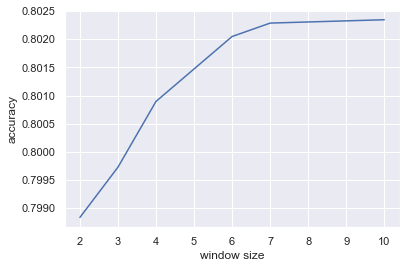

In [66]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('window size')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/plot_window_size.pdf', dpi=500)

## Learning rate

In [86]:
def run_learning_rate_experiments():
    learning_rates = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    
    learning_rate_results = []
    for lr in learning_rates:
        print('Learning rate:', lr)
        #pytorch_geometric_graphs = generate_pytorch_geometric_graphs(window_size=2)
        #train_pyg_graphs, test_pyg_graphs = train_test_split(pytorch_geometric_graphs, test_size=0.33, random_state=42)
        learning_rate_results.append((lr, run_gat_classifier(train_pyg_graphs, test_pyg_graphs, learning_rate=lr)))
    return learning_rate_results

In [87]:
learning_rate_results = run_learning_rate_experiments()
learning_rate_results = [[lr, results[0]] for lr, results in learning_rate_results]

Learning rate: 0.0001
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.47870588302612305
Epoch: 1, Epoch loss 0.4043017625808716
Epoch: 2, Epoch loss 0.37999847531318665
Epoch: 3, Epoch loss 0.360528826713562
Epoch: 4, Epoch loss 0.34516292810440063
Epoch: 5, Epoch loss 0.35222962498664856
Epoch: 6, Epoch loss 0.3370271325111389
Epoch: 7, Epoch loss 0.3367801010608673
Epoch: 8, Epoch loss 0.34466129541397095
Epoch: 9, Epoch loss 0.3475971519947052
Training process has finished.
Final loss 0.3475971519947052
(0.8019379672150638, 0.8125158992622742, 0.793563567806147)
Learning rate: 0.001
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.35780611634254456
Epoch: 1, Epoch loss 0.34166011214256287
Epoch: 2, Epoch loss 0.34958595037460327
Epoch: 3, Epoch loss 0.339209

## <font color='red'>Learning rate results</font>

In [88]:
plot_x = [res[0] for res in learning_rate_results]
plot_y = [res[1] for res in learning_rate_results]
learning_rate_results

[[0.0001, 0.8019379672150638],
 [0.001, 0.8020345683415816],
 [0.005, 0.8012320359058956],
 [0.01, 0.8007415994174208],
 [0.05, 0.7999687904052789],
 [0.1, 0.7984380340927668],
 [0.5, 0.49152882428998174]]

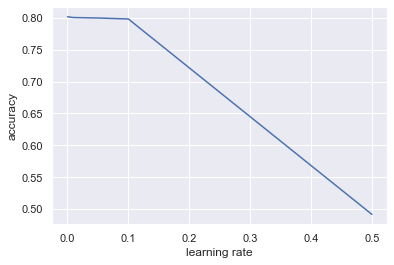

In [89]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('learning rate')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/plot_learning_rate.pdf', dpi=500)

## Dataset size

In [107]:
len(pytorch_geometric_graphs)

407798

In [108]:
def run_training_size_experiments():
    training_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    training_size_results = []
    for ts in training_sizes:
        print('Training size:', ts)
        if ts == 1:
            print('All samples')
            tmp_graphs = pytorch_geometric_graphs
        else:
            tmp_graphs, _ = train_test_split(pytorch_geometric_graphs, train_size=ts, random_state=42)
        
        print('Number of samples:', len(tmp_graphs))
        train_pyg_graphs, test_pyg_graphs = train_test_split(tmp_graphs, test_size=0.33, random_state=42)
        training_size_results.append((ts, run_gat_classifier(train_pyg_graphs, test_pyg_graphs)))
    return training_size_results

In [109]:
training_size_results = run_training_size_experiments()
training_size_results = [[ts, results[0]] for ts, results in training_size_results]

Training size: 0.1
Number of samples: 40779
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.41176360845565796
Epoch: 1, Epoch loss 0.25540682673454285
Epoch: 2, Epoch loss 0.23208990693092346
Epoch: 3, Epoch loss 0.1966618448495865
Epoch: 4, Epoch loss 0.20680241286754608
Epoch: 5, Epoch loss 0.1889016479253769
Epoch: 6, Epoch loss 0.17988401651382446
Epoch: 7, Epoch loss 0.1844499707221985
Epoch: 8, Epoch loss 0.1830679178237915
Epoch: 9, Epoch loss 0.1743452250957489
Training process has finished.
Final loss 0.1743452250957489
(0.8509436766235696, 0.8528119507908611, 0.8533118405627198)
Training size: 0.2
Number of samples: 81559
GATClassifier(
  (conv1): GATConv(100, 10, heads=3)
  (linear1): Linear(in_features=30, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0, Epoch loss 0.40487703680992126
Epoch: 1, Epoch loss 0.4022549092769623
Epoch: 2, Epoch loss 0.3

## <font color='red'>Dataset size results</font>

In [110]:
plot_x = [res[0] for res in training_size_results]
plot_y = [res[1] for res in training_size_results]
training_size_results

[[0.1, 0.8509436766235696],
 [0.2, 0.8593720973434887],
 [0.3, 0.8525463192311503],
 [0.4, 0.8558981980308378],
 [0.5, 0.8548010759879323],
 [0.6, 0.8575374021599128],
 [0.7, 0.8546103055136833],
 [0.8, 0.8485960300578679],
 [0.9, 0.8445292116648502],
 [1, 0.8024061111358807]]

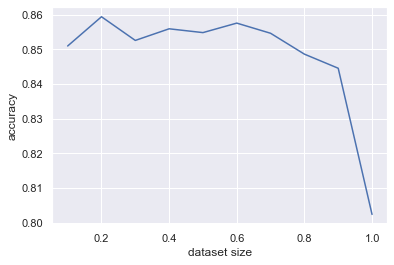

In [111]:
fig = sns.lineplot(x=plot_x, y=plot_y)
fig.set_xlabel('dataset size')
fig.set_ylabel('accuracy')
fig.get_figure().savefig('figures/training_size_rate.pdf', dpi=500)

## Draw an exemplar graph-of-words graph with 15 nodes and 3 window size

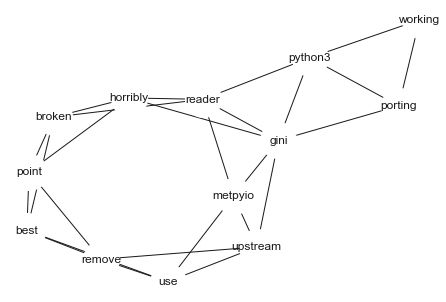

In [77]:
text = df['body'][df['number_of_words_of_body'] == 15].values[6]
text = text.replace(',', '')
text = text.replace('.', '')
g = create_graph_of_words(text, 3)
nx.draw_kamada_kawai(g, with_labels=True, node_color='white', node_size=1300)
plt.savefig("Graph1.pdf")
plt.show()